In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

# 5 year mean state evalution and error

In this notebook, we show how we generate error growth plot, i.e., Figure 7, 8 in "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation", Hu et al. 2024, arXiv preprint:2306.08754.

## Set data path

All the simulation output, saved model weights, and preprocessed data used in Hu et al. 2024 "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation" are provided at zenodo (https://zenodo.org/records/12797810) that you can download. Please change the following path to your path that contains all downloaded folders.

In [2]:
data_path = '/global/homes/z/zeyuanhu/scratch/hu_etal2024_data_v2/'

In [3]:
# Generate a list of filenames
filenames = data_path+'data/h0/5year/unet_v5/huber_rop/*.eam.h0.000[3-8]*.nc'
ds_nn = xr.open_mfdataset(filenames)

filenames = data_path+'data/h0/5year/unet_v5/huber_step/*.eam.h0.000[3-8]*.nc'
ds_nn2 = xr.open_mfdataset(filenames)
# ds_nn2 = ds_nn2.sel(time=ds_nn2.time[1:])

filenames = data_path+'data/h0/5year/mmf_ref/*.eam.h0.000[3-8]*.nc'
ds_sp = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01)
# ds_sp = ds_sp.sel(time=ds_sp.time[1:])

filenames = data_path+'data/h0/5year/mmf_b/*.eam.h0.000[3-8]*.nc'

ds_sp2 = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01)
# ds_sp2 = ds_sp2.sel(time=ds_sp2.time[1:])

In [4]:
ds_grid = xr.open_dataset(data_path+'data/data_grid/ne4pg2_scrip.nc')
grid_area = ds_grid['grid_area']
area_weight = grid_area/np.sum(grid_area)

In [5]:
t_mmf = np.average(ds_sp.T[:,-1,:].values, weights=area_weight,axis=1)
t_nn = np.average(ds_nn.T[:,-1,:].values, weights=area_weight,axis=1)
t_nn2 = np.average(ds_nn2.T[:,-1,:].values, weights=area_weight,axis=1)

In [6]:
xtime = np.arange(61)
lat_1d = ds_sp.lat[0].values

def get_tcp_mean(ds, area_weight):
    cld = ds.CLDICE + ds.CLDLIQ
    ps = ds.PS
    p_interface = ds.hyai*ds.P0 + ds.hybi*ds.PS
    p_interface = p_interface.values
    dp = p_interface[:,1:61,:] - p_interface[:,0:60,:]
    ggr = 9.81
    tcp = np.sum(cld*dp,axis=1)/9.81
    tcp_mean = np.average(tcp, weights=area_weight,axis=1)
    return tcp_mean

area_weight_nh = np.where(lat_1d>30, area_weight, 0)
area_weight_sh = np.where(lat_1d<-30, area_weight, 0)
area_weight_tropics = np.where((lat_1d > -30) & (lat_1d < 30), area_weight, 0)

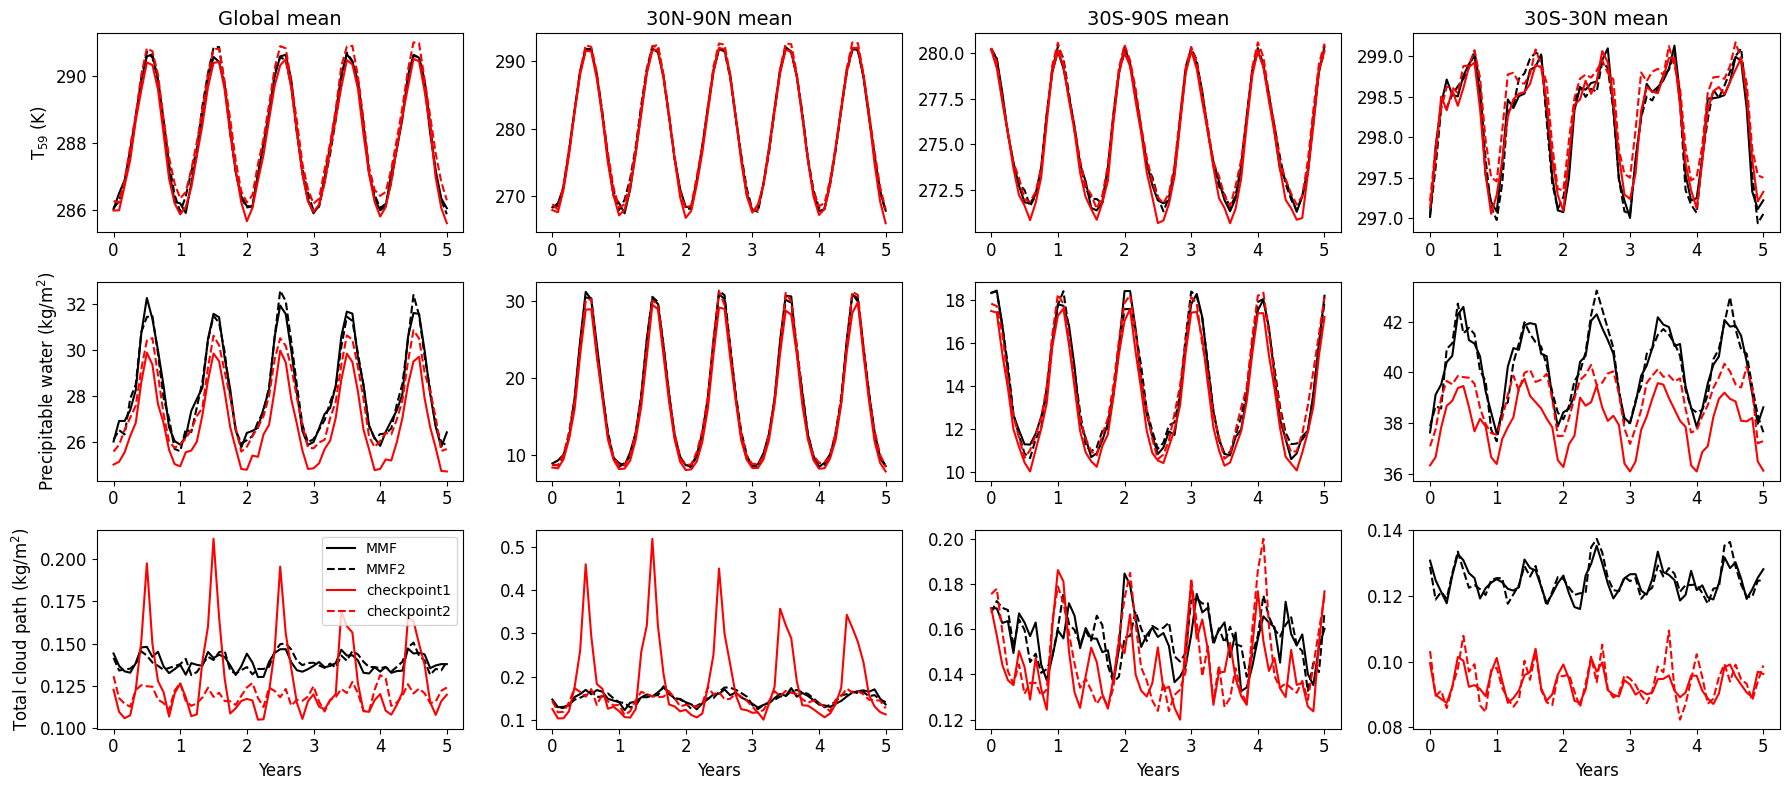

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(18, 8))

# Define the time axis
xtime = np.arange(61)/12

# Titles for columns
column_titles = ['Global mean', '30N-90N mean', '30S-90S mean', '30S-30N mean']

# Y-axis labels for rows
row_ylabels = [
    'T$_{59}$ (K)',
    'Precipitable water (kg/m$^2$)',
    'Total cloud path (kg/m$^2$)'
]

# Define area weights
weights = ['area_weight', 'area_weight_nh', 'area_weight_sh', 'area_weight_tropics']
weights_dict = {
    'area_weight': area_weight,
    'area_weight_nh': area_weight_nh,
    'area_weight_sh': area_weight_sh,
    'area_weight_tropics': area_weight_tropics,
}

# Define variables and associated averaging functions
variables = ['T', 'TMQ', 'TCP']
get_mean_function = {
    'T': lambda ds, w: np.average(ds.T[:, -1, :].values, weights=w, axis=1),
    'TMQ': lambda ds, w: np.average(ds.TMQ[:, :].values, weights=w, axis=1),
    'TCP': lambda ds, w: get_tcp_mean(ds, w)
}

# Generate subplots
for row, var in enumerate(variables):
    for col, weight_key in enumerate(weights):
        weight = weights_dict[weight_key]
        t_mmf = get_mean_function[var](ds_sp, weight)
        t_mmf2 = get_mean_function[var](ds_sp2, weight)
        t_nn = get_mean_function[var](ds_nn, weight)
        t_nn2 = get_mean_function[var](ds_nn2, weight)
        
        axes[row, col].plot(xtime, t_mmf, label='MMF', color='black')
        axes[row, col].plot(xtime, t_mmf2, label='MMF2', color='black', linestyle='dashed')
        axes[row, col].plot(xtime, t_nn, label='checkpoint1', color='red')
        axes[row, col].plot(xtime, t_nn2, label='checkpoint2', color='red', linestyle='dashed')
        axes[row, col].tick_params(axis='both', labelsize=12) 
        # Set column titles
        if row == 0:
            axes[row, col].set_title(column_titles[col],fontsize=14)
        
        # Set row y-labels
        if col == 0:
            axes[row, col].set_ylabel(row_ylabels[row],fontsize=12)
        
        # Set x-label for the last row
        if row == 2:
            axes[row, col].set_xlabel("Years",fontsize=12)
        
        # Add legend to the first row, last column
        if row == 2 and col == 0:
            axes[row, col].legend(fontsize=10,loc='upper right')

# Adjust layout and display the plot
plt.tight_layout()
# plt.savefig('time_series_mean_5years.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.show()

In [16]:
data_path = '/media/peter/CrucialBX500/data/ClimSim/hu_etal2024_data/'
# Generate a list of filenames
filenames = data_path+'h0/1year/RNN/65791/*.eam.h0.0003-*.nc'
#/media/peter/CrucialBX500/data/ClimSim/hu_etal2024_data/h0/1year/RNN/perturb_sgru_62843/*.eam.h0.0003-0[1-4].nc
print(filenames)
ds_nn = xr.open_mfdataset(filenames)

filenames = data_path+'h0/1year/RNN/perturb_sgru_62843/*.eam.h0.0003-*.nc'
ds_nn2 = xr.open_mfdataset(filenames)
# ds_nn2 = ds_nn2.sel(time=ds_nn2.time[1:])

filenames = data_path+'h0/5year/mmf_ref/*.eam.h0.0003-*.nc'
ds_sp = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01)
# ds_sp = ds_sp.sel(time=ds_sp.time[1:])

#filenames = data_path+'h0/5year/mmf_b/*.eam.h0.0003-*.nc'

#ds_sp2 = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01)
# ds_sp2 = ds_sp2.sel(time=ds_sp2.time[1:])


/media/peter/CrucialBX500/data/ClimSim/hu_etal2024_data/h0/1year/RNN/65791/*.eam.h0.0003-*.nc


In [13]:
t_nn2.shape

(12,)

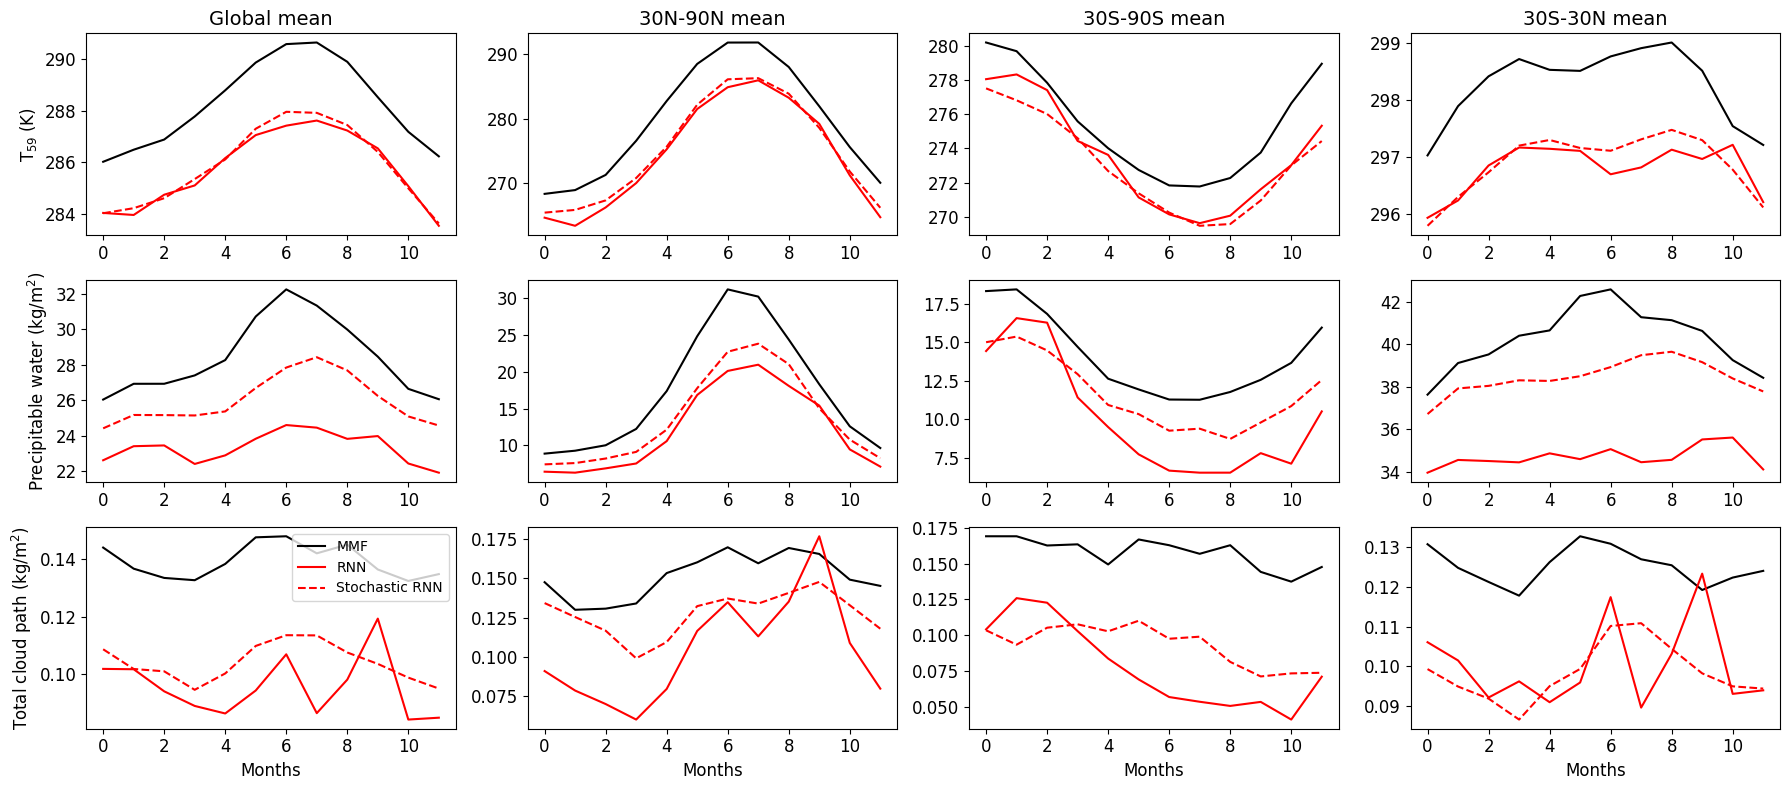

In [18]:
ds_grid = xr.open_dataset(data_path+'data_grid/ne4pg2_scrip.nc')
grid_area = ds_grid['grid_area']
area_weight = grid_area/np.sum(grid_area)
t_mmf = np.average(ds_sp.T[:,-1,:].values, weights=area_weight,axis=1)
t_nn = np.average(ds_nn.T[:,-1,:].values, weights=area_weight,axis=1)
t_nn2 = np.average(ds_nn2.T[:,-1,:].values, weights=area_weight,axis=1)

xtime = np.arange(61)
#lat_1d = ds_sp.lat[0].values
ds2 = xr.open_dataset(data_path+'data_grid/E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2.eam.h0.0001-01.nc')
lat_1d = ds2.lat

def get_tcp_mean(ds, area_weight):
    cld = ds.CLDICE + ds.CLDLIQ
    ps = ds.PS
    p_interface = ds.hyai*ds.P0 + ds.hybi*ds.PS
    p_interface = p_interface.values
    dp = p_interface[:,1:61,:] - p_interface[:,0:60,:]
    ggr = 9.81
    tcp = np.sum(cld*dp,axis=1)/9.81
    tcp_mean = np.average(tcp, weights=area_weight,axis=1)
    return tcp_mean

area_weight_nh = np.where(lat_1d>30, area_weight, 0)
area_weight_sh = np.where(lat_1d<-30, area_weight, 0)
area_weight_tropics = np.where((lat_1d > -30) & (lat_1d < 30), area_weight, 0)
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 3 rows and 4 columns
fig, axes = plt.subplots(3, 4, figsize=(18, 8))

# Define the time axis
xtime = np.arange(12) # np.arange(61)/12

# Titles for columns
column_titles = ['Global mean', '30N-90N mean', '30S-90S mean', '30S-30N mean']

# Y-axis labels for rows
row_ylabels = [
    'T$_{59}$ (K)',
    'Precipitable water (kg/m$^2$)',
    'Total cloud path (kg/m$^2$)'
]

# Define area weights
weights = ['area_weight', 'area_weight_nh', 'area_weight_sh', 'area_weight_tropics']
weights_dict = {
    'area_weight': area_weight,
    'area_weight_nh': area_weight_nh,
    'area_weight_sh': area_weight_sh,
    'area_weight_tropics': area_weight_tropics,
}

# Define variables and associated averaging functions
variables = ['T', 'TMQ', 'TCP']
get_mean_function = {
    'T': lambda ds, w: np.average(ds.T[:, -1, :].values, weights=w, axis=1),
    'TMQ': lambda ds, w: np.average(ds.TMQ[:, :].values, weights=w, axis=1),
    'TCP': lambda ds, w: get_tcp_mean(ds, w)
}

# Generate subplots
for row, var in enumerate(variables):
    for col, weight_key in enumerate(weights):
        weight = weights_dict[weight_key]
        t_mmf = get_mean_function[var](ds_sp, weight)
     #   t_mmf2 = get_mean_function[var](ds_sp2, weight)
        t_nn = get_mean_function[var](ds_nn, weight)
        t_nn2 = get_mean_function[var](ds_nn2, weight)
        
        axes[row, col].plot(xtime, t_mmf, label='MMF', color='black')
        #axes[row, col].plot(xtime, t_mmf2, label='MMF2', color='black', linestyle='dashed')
        axes[row, col].plot(xtime, t_nn, label='RNN', color='red')
        axes[row, col].plot(xtime, t_nn2, label='Stochastic RNN', color='red', linestyle='dashed')
        axes[row, col].tick_params(axis='both', labelsize=12) 
        # Set column titles
        if row == 0:
            axes[row, col].set_title(column_titles[col],fontsize=14)
        
        # Set row y-labels
        if col == 0:
            axes[row, col].set_ylabel(row_ylabels[row],fontsize=12)
        
        # Set x-label for the last row
        if row == 2:
            axes[row, col].set_xlabel("Months",fontsize=12)
        
        # Add legend to the first row, last column
        if row == 2 and col == 0:
            axes[row, col].legend(fontsize=10,loc='upper right')

# Adjust layout and display the plot
plt.tight_layout()
# plt.savefig('time_series_mean_5years.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.show()

Now let's plot the 5-year mean RMSE. Below we remove the 1st month spinup period

In [8]:
# Generate a list of filenames
filenames = data_path+'data/h0/5year/unet_v5/huber_rop/*.eam.h0.000[3-8]*.nc'
ds_nn = xr.open_mfdataset(filenames)
ds_nn = ds_nn.sel(time=ds_nn.time[1:])

filenames = data_path+'data/h0/5year/unet_v5/huber_step/*.eam.h0.000[3-8]*.nc'
ds_nn2 = xr.open_mfdataset(filenames)
ds_nn2 = ds_nn2.sel(time=ds_nn2.time[1:])

filenames = data_path+'data/h0/5year/mmf_ref/*.eam.h0.000[3-8]*.nc'
ds_sp = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01)
ds_sp = ds_sp.sel(time=ds_sp.time[1:])

filenames = data_path+'data/h0/5year/mmf_b/*.eam.h0.000[3-8]*.nc'

ds_sp2 = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01)
ds_sp2 = ds_sp2.sel(time=ds_sp2.time[1:])

In [9]:
ps_sp = ds_sp.PS
p_interface = ds_sp.hyai*ds_sp.P0 + ds_sp.hybi*ds_sp.PS
p_interface = p_interface.values
dp = p_interface[:,1:61,:] - p_interface[:,0:60,:]
area = ds_sp.area
area_weight1 = area.values[:,np.newaxis,:]
total_weight = dp*area_weight1
total_weight = total_weight.mean(axis=0)
total_weight = total_weight/total_weight.sum()
lev = ds_nn.lev.values

/tmp/ipykernel_1816107/92784388.py:49: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


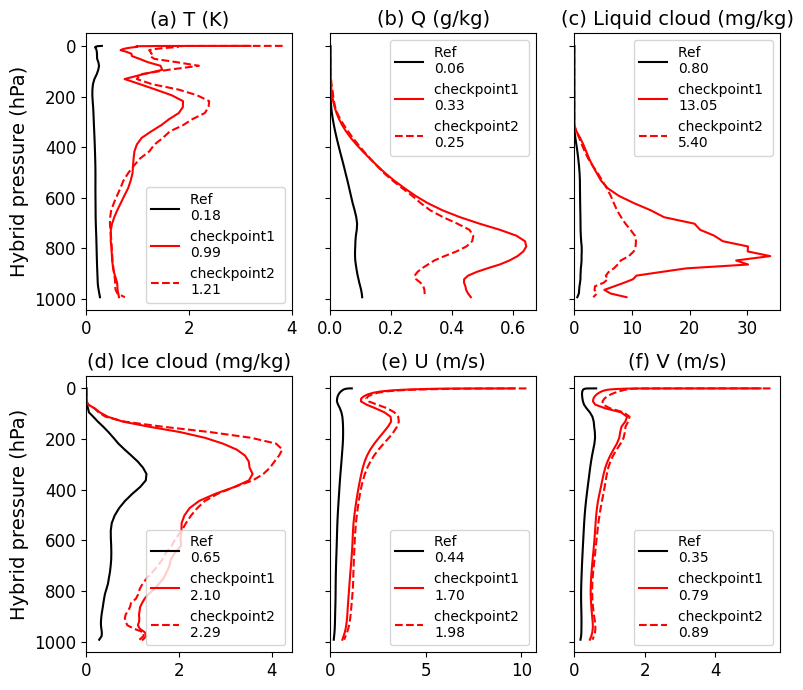

In [10]:
variables = ['T', 'Q', 'CLDLIQ', 'CLDICE', 'U', 'V']
scaling_dict = {'T': 1.0, 'Q': 1000.0, 'CLDLIQ': 1e6, 'CLDICE': 1e6, 'U': 1.0, 'V': 1.0}  # Scaling factors
units_dict = {'T': 'K', 'Q': 'g/kg', 'CLDLIQ': 'mg/kg', 'CLDICE': 'mg/kg', 'U': 'm/s', 'V': 'm/s'}  # Units
titles = [
    '(a) T',
    '(b) Q',
    '(c) Liquid cloud',
    '(d) Ice cloud',
    '(e) U',
    '(f) V',
]  # Main titles with subplot labels

fig, axes = plt.subplots(2, 3, figsize=(8, 7), sharey=True, constrained_layout=True)  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten axes for easier iteration

for ax, var, title in zip(axes, variables, titles):
    # Use specified scaling for the variable
    scaling = scaling_dict[var]

    # Compute time-mean and RMSE for each variable
    nn_tmean = (ds_nn[var]).mean(dim=('time')).compute().values * scaling
    nn_tmean2 = (ds_nn2[var]).mean(dim=('time')).compute().values * scaling
    sp_tmean = (ds_sp[var]).mean(dim=('time')).compute().values * scaling
    sp_tmean2 = (ds_sp2[var]).mean(dim=('time')).compute().values * scaling

    nn_rmse = np.sqrt(np.average((sp_tmean - nn_tmean) ** 2, axis=1, weights=area_weight))
    nn_rmse2 = np.sqrt(np.average((sp_tmean - nn_tmean2) ** 2, axis=1, weights=area_weight))
    mmf_rmse = np.sqrt(np.average((sp_tmean - sp_tmean2) ** 2, axis=1, weights=area_weight))

    nn_rmse_global = np.sqrt(np.average((sp_tmean - nn_tmean) ** 2, weights=total_weight))
    nn_rmse_global2 = np.sqrt(np.average((sp_tmean - nn_tmean2) ** 2, weights=total_weight))
    mmf_rmse_global = np.sqrt(np.average((sp_tmean - sp_tmean2) ** 2, weights=total_weight))

    # Plot on the corresponding axis
    ax.plot(mmf_rmse, lev, label=f'Ref \n{mmf_rmse_global:.2f}', linestyle='-', color='black')
    ax.plot(nn_rmse, lev, label=f'checkpoint1 \n{nn_rmse_global:.2f}', color='red')
    ax.plot(nn_rmse2, lev, label=f'checkpoint2 \n{nn_rmse_global2:.2f}', color='red', linestyle='dashed')
    ax.set_xlim(left=0)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_title(title+f' ({units_dict[var]})', fontsize=14, loc='center')  # Add main title with subplot label
    # ax.set_xlabel(f'{units_dict[var]}', fontsize=14)  # Keep unit in x-label
    ax.invert_yaxis()  # Reverse the y-axis
    ax.legend(fontsize=10)

# Set a shared y-label for the first column
axes[0].set_ylabel('Hybrid pressure (hPa)', fontsize=14)
axes[3].set_ylabel('Hybrid pressure (hPa)', fontsize=14)
plt.gca().invert_yaxis() 
plt.tight_layout()
# plt.savefig('state_rmse_profiles_and_scalar.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.show()